In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
# Parameters
batch_size = 64
learning_rate = 5e-4

# Transform for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
])

In [3]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from nn_utils import preprocess_and_save_images
# Example usage
input_directory_train = '../data/UAV/train_images'
output_directory_train = '../data/UAV/preprocessed/train_images'
preprocess_and_save_images(input_directory_train, output_directory_train)

input_directory_test = '../data/UAV/test_images'
output_directory_test = '../data/UAV/preprocessed/test_images'
preprocess_and_save_images(input_directory_test, output_directory_test)

In [7]:

class UAVChunkedDataset(Dataset):
    def __init__(self, directory, transform=None):
        """
        Initializes the dataset, listing all the preprocessed image chunks.
        :param directory: Directory where preprocessed image chunks are stored.
        :param transform: Transformations to be applied to the images.
        """
        self.directory = directory
        self.transform = transform
        # List all images in the preprocessed directory
        self.image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        """
        Returns the total number of image chunks in the dataset.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Fetches the idx-th image chunk from the dataset, applying transformations if any.
        """
        img_path = os.path.join(self.directory, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # Replace None with a dummy tensor
        dummy = torch.tensor([])  # An empty tensor as a placeholder
        return image, dummy

from torchvision.transforms import functional as TF
import torch

class HistogramStretchingTransform:
    def __call__(self, img):
        """
        Perform histogram stretching on an image tensor so that its pixel value range spans from 0 to 255.
        
        :param img: Image tensor of shape (C, H, W) with pixel values in [0, 1].
        :return: Transformed image tensor with pixel values stretched to [0, 1] range.
        """
        # Assuming img is a PyTorch tensor with values in [0, 1]
        min_val = torch.min(img)
        max_val = torch.max(img)
        stretched_img = (img - min_val) / (max_val - min_val)  # Normalize to [0, 1]
        return stretched_img

# Now, incorporate this transform into your existing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    HistogramStretchingTransform(),  # Add the custom histogram stretching transform here
])

# Create the dataset
train_dataset = UAVChunkedDataset(directory='../data/UAV/train_images', transform=transform)
test_dataset = UAVChunkedDataset(directory='../data/UAV/test_images', transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [26]:
# # Download and load EuroSAT dataset
# import requests
# import zipfile
# import os

# # Directory to check
# directory_path = '../data/eurosat/2750/'

# # URL of the file to be downloaded
# url = 'https://madm.dfki.de/files/sentinel/EuroSAT.zip'
# filename = url.split('/')[-1]  # Extract filename
# zip_path = os.path.join('./', filename)  # Path to save the zip file

# # Check if the specific directory exists
# if not(os.path.exists(directory_path)):
#     print(f"Directory {directory_path} not found. Proceeding with download...")
    
#     # Download the file
#     try:
#         # For a more secure approach, replace verify=False with the path to a valid CA bundle
#         response = requests.get(url, verify=False)  # Not recommended for production
#         with open(zip_path, 'wb') as f:
#             f.write(response.content)
#         print("Download complete.")
        
#         # Unzip the file
#         print("Unzipping file...")
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall('../data/eurosat/')  # Extract to the specified directory
#         print("Unzipping complete.")
        
#         # Optionally, remove the zip file after extraction
#         # os.remove(zip_path)
#     except requests.exceptions.SSLError as e:
#         print(f"SSL Error occurred: {e}")
    
#     # Optionally, remove the zip file after extraction
#     os.remove(zip_path)
# else:
#     print(f"Directory {directory_path} already exists. Aborting download.")

In [27]:
# dataset = datasets.EuroSAT(root='../data/', download=False, transform=transform)


# # Split dataset into training and validation
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [28]:
# import matplotlib.pyplot as plt
# from torchvision.utils import make_grid

# def show_images(images, nmax=2):
#     fig, ax = plt.subplots(figsize=(nmax * 5, 5))
#     ax.set_xticks([]); ax.set_yticks([])
#     ax.imshow(make_grid(images.detach()[:nmax], nrow=nmax).permute(1, 2, 0))

# # Get a batch of training data
# images, _ = next(iter(train_loader))

# # Show images
# show_images(images, nmax=5)

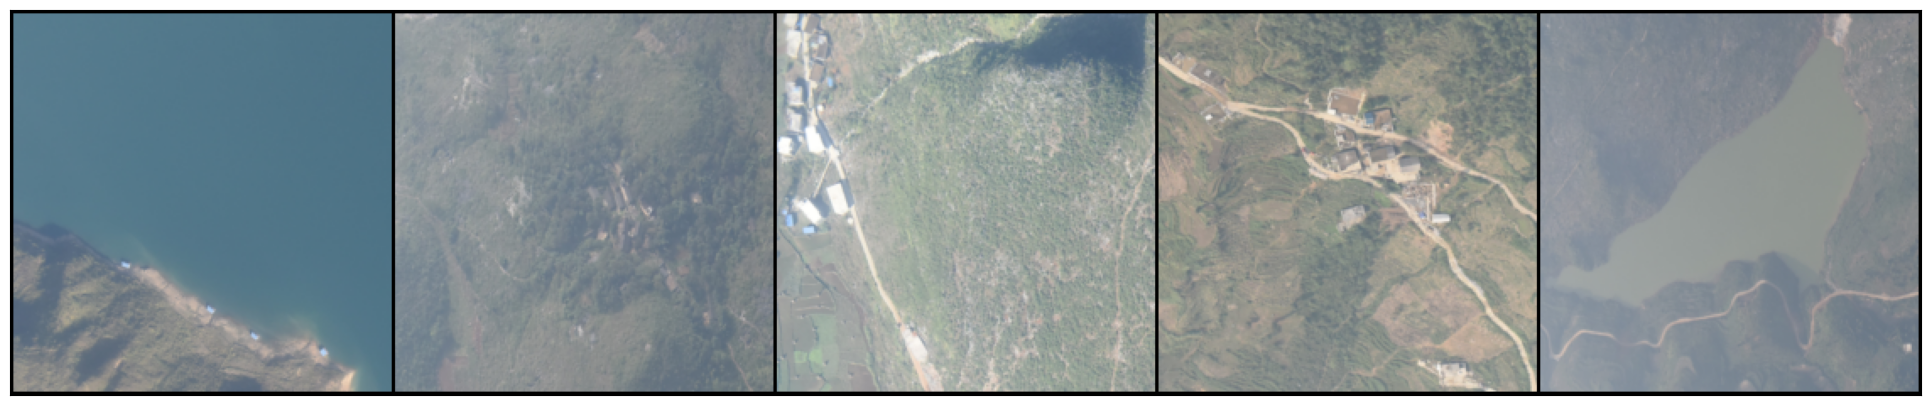

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images(images, nmax=2):
    fig, ax = plt.subplots(figsize=(nmax * 5, 5))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=nmax).permute(1, 2, 0))

# Get a batch of training data
images, _ = next(iter(train_loader))

# Show images
show_images(images, nmax=5)

In [9]:
# Function to add Gaussian noise
def add_gaussian_noise(images, mean=0., std=0.2):
    return torch.clip(images + torch.randn_like(images) * std + mean, 0, 1)

In [14]:
from nn_utils import DnCNN
model = DnCNN(in_nc=3, out_nc=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Create a writer instance
writer = SummaryWriter('../data/nn/runs/dncnn_experiment_2')

In [ ]:
# Initialize early stopping parameters
best_val_loss = float('inf')  # Initialize with a very high value
patience = 20  # Number of epochs to wait for improvement before stopping the training
patience_counter = 0  # Counter to keep track of epochs without improvement


# Training
num_epochs = 300
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        noise_img = add_gaussian_noise(img).to(device)
        optimizer.zero_grad()
        output = model(noise_img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * img.size(0)
    train_loss = train_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data
            img = img.to(device)
            noise_img = add_gaussian_noise(img).to(device)
            output = model(noise_img)
            loss = criterion(output, img)
            val_loss += loss.item() * img.size(0)
    val_loss = val_loss / len(val_loader.dataset)

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter if there's an improvement
    else:
        patience_counter += 1  # Increment counter if no improvement
    
    # Check if early stopping is needed
    if patience_counter > patience:
        print(f'Early stopping triggered at epoch {epoch+1}. No improvement in validation loss for {patience} consecutive epochs.')
        break  # Break out of the loop to stop training
        
    # Log the losses
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Training completed.')

Epoch [1/300], Train Loss: 0.0517, Val Loss: 0.0386
Epoch [2/300], Train Loss: 0.0332, Val Loss: 0.0300
Epoch [3/300], Train Loss: 0.0245, Val Loss: 0.0226
Epoch [4/300], Train Loss: 0.0176, Val Loss: 0.0172
Epoch [5/300], Train Loss: 0.0119, Val Loss: 0.0115
Epoch [6/300], Train Loss: 0.0091, Val Loss: 0.0113
Epoch [7/300], Train Loss: 0.0081, Val Loss: 0.0117
Epoch [8/300], Train Loss: 0.0065, Val Loss: 0.0084
Epoch [9/300], Train Loss: 0.0060, Val Loss: 0.0067
Epoch [10/300], Train Loss: 0.0058, Val Loss: 0.0083
Epoch [11/300], Train Loss: 0.0052, Val Loss: 0.0071
Epoch [12/300], Train Loss: 0.0048, Val Loss: 0.0059
Epoch [13/300], Train Loss: 0.0049, Val Loss: 0.0068
Epoch [14/300], Train Loss: 0.0044, Val Loss: 0.0047
Epoch [15/300], Train Loss: 0.0054, Val Loss: 0.0068
Epoch [16/300], Train Loss: 0.0044, Val Loss: 0.0041
Epoch [17/300], Train Loss: 0.0045, Val Loss: 0.0053
Epoch [18/300], Train Loss: 0.0041, Val Loss: 0.0049
Epoch [19/300], Train Loss: 0.0038, Val Loss: 0.0063
Ep

In [17]:
torch.save(model.state_dict(), "../data/nn/dncnn_trained_2.pth")